In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the CSV file
data_path = 'train.csv'  # Replace with the correct path to your CSV file
df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
print(df.head())

# Define the base directory for images
base_image_dir = 'colored_images'  # Replace with the correct path to your image base directory

# Define a mapping from directory names to labels
label_mapping = {
    'No_DR': 0,
    'Mild': 1,
    'Moderate': 2,
    'Severe': 3,
    'Proliferate_DR': 4
}

# Preprocess images and labels
def preprocess_data(df, base_image_dir, label_mapping, img_size=(224, 224)):
    images = []
    labels = []

    for index, row in df.iterrows():
        for label_name, label_num in label_mapping.items():
            img_dir = os.path.join(base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                image = cv2.imread(img_path)
                image = cv2.resize(image, img_size)
                image = image / 255.0  # Normalize to [0, 1]
                images.append(image)
                labels.append(label_num)

    images = np.array(images)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=5)  # One-hot encode the labels (assuming 5 classes)

    return images, labels

images, labels = preprocess_data(df, base_image_dir, label_mapping)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")



        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
Training data shape: (2929, 224, 224, 3)
Validation data shape: (733, 224, 224, 3)


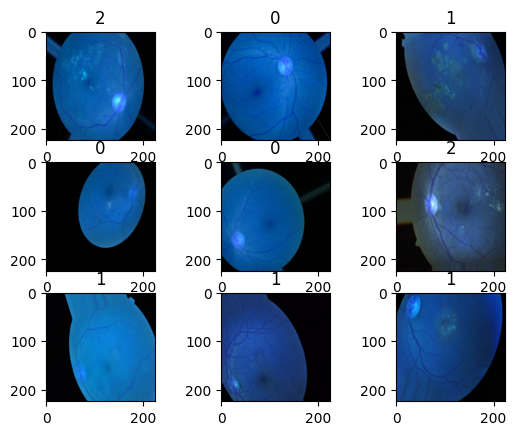

In [3]:
#give augmented images of all types in a sigle frame of one image as output
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Display the first few images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
        plt.title(np.argmax(y_batch[i]))
    plt.show()
    break


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))  # Add a dense layer
cnn_model.add(Dense(5, activation='softmax'))  # Output layer with 5 classes (adjust as needed)

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))





Epoch 1/5


92/92 [==============================] - 67s 712ms/step - loss: 0.9793 - accuracy: 0.6681 - val_loss: 0.8012 - val_accuracy: 0.6971
Epoch 2/5
92/92 [==============================] - 45s 487ms/step - loss: 0.7534 - accuracy: 0.7197 - val_loss: 0.7674 - val_accuracy: 0.7203
Epoch 3/5
92/92 [==============================] - 45s 485ms/step - loss: 0.7229 - accuracy: 0.7340 - val_loss: 0.7759 - val_accuracy: 0.7353
Epoch 4/5
92/92 [==============================] - 45s 492ms/step - loss: 0.6982 - accuracy: 0.7385 - val_loss: 0.7375 - val_accuracy: 0.7340
Epoch 5/5
92/92 [==============================] - 46s 495ms/step - loss: 0.6793 - accuracy: 0.7470 - val_loss: 0.7569 - val_accuracy: 0.7408


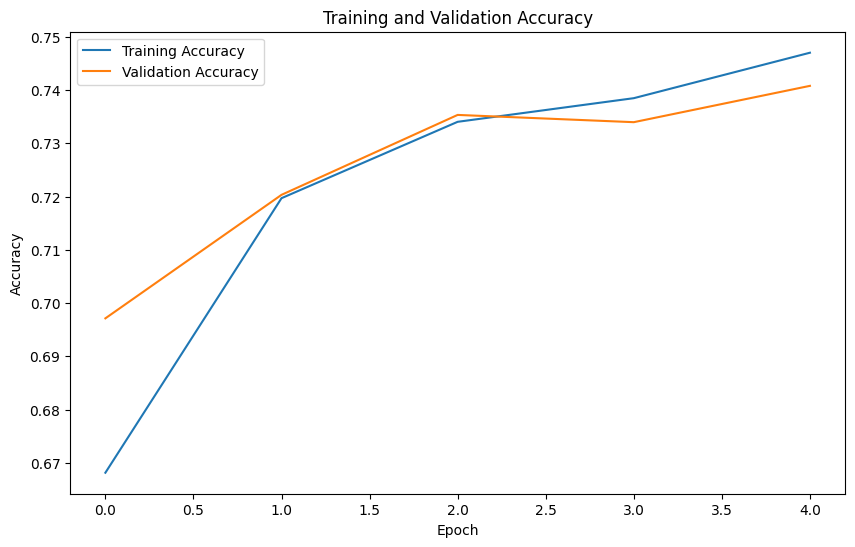

In [6]:
#draw the plots of the model for accuracy and loss

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(cnn_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

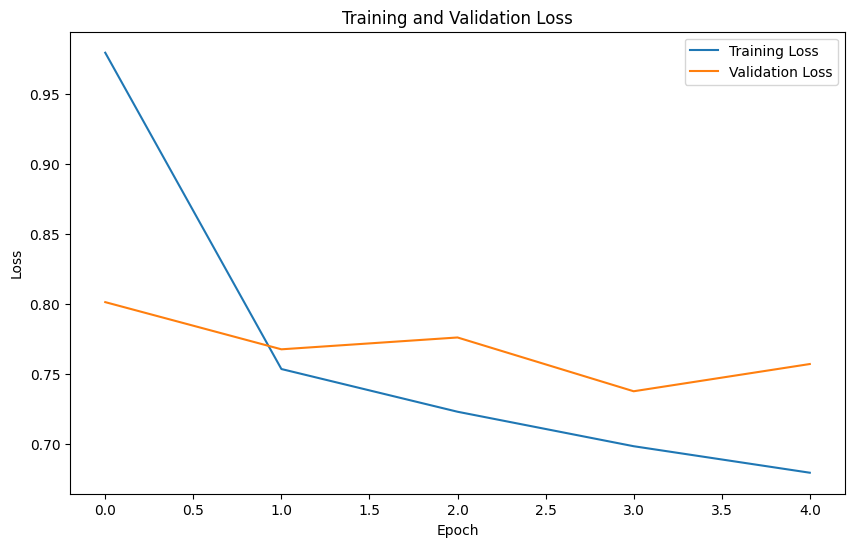

In [7]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(cnn_model.history.history['loss'], label='Training Loss')
plt.plot(cnn_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

23/23 [==============================] - 2s 95ms/step


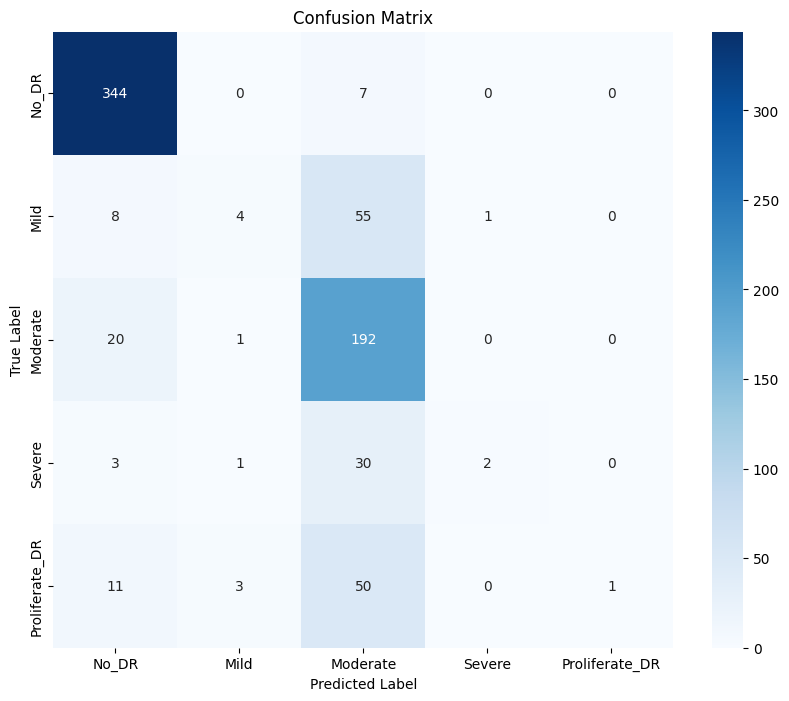

In [8]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predictions for the validation data
y_pred = cnn_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

23/23 [==============================] - 2s 94ms/step


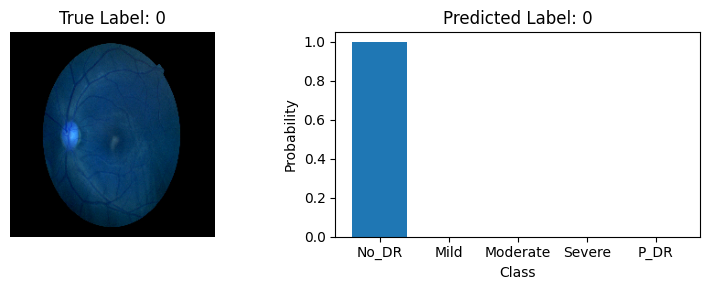

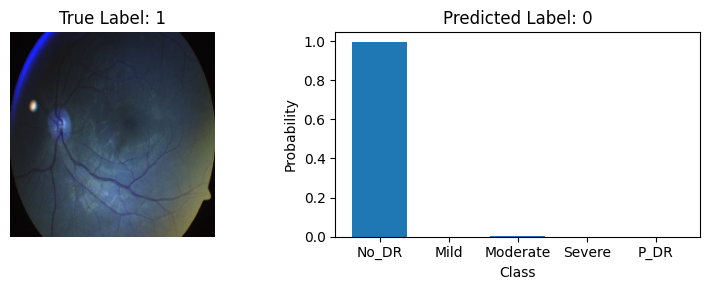

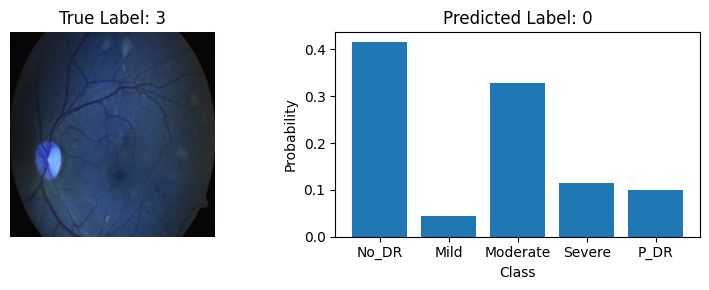

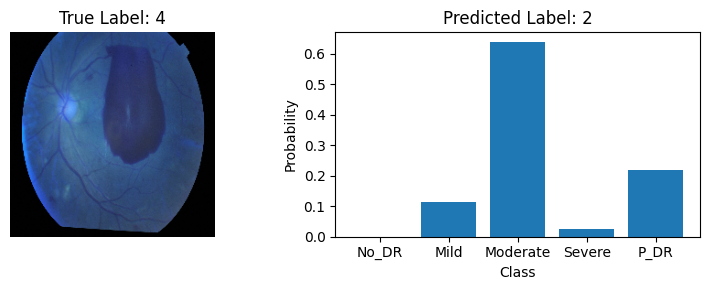

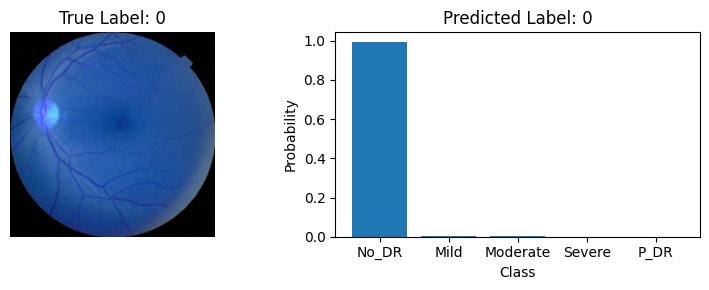

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained model (cnn_model and ann_model) already

# Get predictions for test data
cnn_predictions = cnn_model.predict(X_val)

# Convert one-hot encoded labels back to class labels
predicted_classes = np.argmax(cnn_predictions, axis=1)

# Visualize a few test images along with their predicted labels
num_samples_to_visualize = 5
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[i])
    plt.title(f"True Label: {np.argmax(y_val[i])}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(range(5), cnn_predictions[i])
    plt.xticks(range(5), ['No_DR', 'Mild', 'Moderate', 'Severe', 'P_DR'])
    plt.title(f"Predicted Label: {predicted_classes[i]}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.tight_layout()

    plt.show()


In [ ]:
#save the model
#cnn_model.save('cnn_model.h5')